# Расстояния от ARG/LYS до поверхности белка

## Введение и постановка задачи

Перед отправой в масс-спектрометр белок режется трипсином по аминокислотам ARG и LYS (но, оказывается, не по всем подряд). На картинке показан белок P02787, зеленым показаны аминокислоты, по которым происходил разрез (я их называла cleaved), а синим - по которым не происходил (not cleaved).
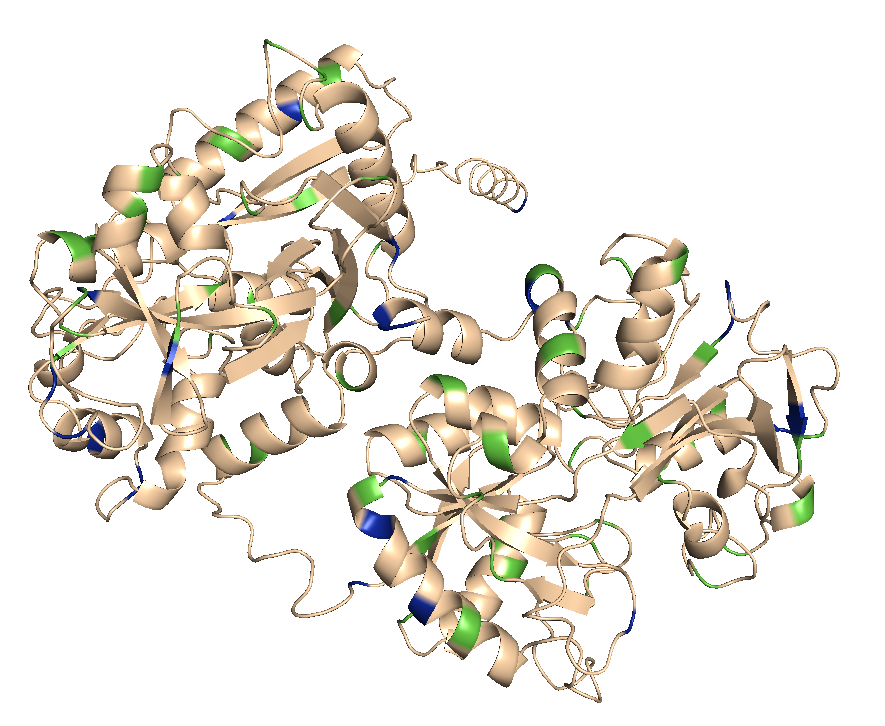

Гипотеза: трипсин разрезает ARG/LYS близко к поверхности белка => чем больше белок, тем более вероятны различия cleaved/not cleaved

План работы ноутбука:
* поиск расстояния от каждого ARG/LYS до центра масс белка (не супер осмысленное, как мне кажется, действие, потому что центр масс белка и расстояние от поверхности не особо связаны: например, на рисунке выше центр где-то в центральной дырке). Я не стала убирать этот кусок, мб кому и пригодится :)
* поиск расстояния от каждого ARG/LYS до поверхности белка
* статистическая проверка гипотезы

Оффтоп: в ноутбуке все делается для одного белка, но я так же приложу скрипт, который делает все то же самое и для всех белков из списка.

## Подготовка файлов

Установим нужные библиотеки (скорее всего, не все из них стоят у вас изначально). Это можно сделать прямо из ноутбука одной из комманд (ставите ! в начале строчки -> она будет работать как коммандная строка): 

    !pip install ...
    !conda install ...
    
Разница между pip и conda в том, куда будет установлена библиотека (pip устанавливает библиотеку на весь компьютер, а conda - в текущий environment (их можно сделать много и в каждый установить свои библиотеки)

Также можно устанавливать библиотеки сразу с GitHub, например, BioPython можно установить так:

    ! pip install git+git://github.com/JoaoRodrigues/biopython.git

Перед началом работы стоит установить [Pymol](https://pymol.org/2/) - это визуализатор структур, там можно много всего крутого делать (там написано что-то про лицензию, у меня ее нет и все работает нормально): 
* [знакомство с Pymol](https://drive.google.com/file/d/1_-osabHw95Ip5i1rDbXXJQyy1anvic7w/view)
* [документация](https://pymolwiki.org/index.php/Main_Page)

In [1]:
import Bio
from Bio import *
from Bio.PDB import *
from Bio import SeqIO
from Bio import Struct
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import nglview as nv
#import pytraj as pt
from pytraj import view
import requests

In [2]:
NAME = 'P02787' #Uniprot белка, с которым будем работать

In [3]:
dir = 'Desktop/Biss/project2' #рабочая папка

In [4]:
cd

/home/gressy


In [5]:
cd $dir

/home/gressy/Desktop/Biss/project2


In [6]:
url = 'https://alphafold.ebi.ac.uk/files/AF-'+NAME+'-F1-model_v1.pdb'
r = requests.get(url)
with open('AF-'+NAME+'-F1-model_v1.pdb', 'wb') as f:
    f.write(r.content)

Уже можно открыть структуру через Pymol, но можно посмотреть ее и прямо в ноутбуке. Для этого есть библиотека [nglview](http://nglviewer.org/nglview/latest/api.html) (она работает +- как pymol, не всегда, но для быстрого просмотра самое то)

In [7]:
v = nv.show_structure_file('AF-'+NAME+'-F1-model_v1.pdb',)
v.clear_representations()
v.add_representation(repr_type="cartoon", color = "blue")
v

NGLWidget()

UP000005640_9606.fasta - файл, в котором лежат последовательности белков. Ищем в нем последовательность нашего белка P

In [8]:
for seq_record in SeqIO.parse("UP000005640_9606.fasta", "fasta"):
    if seq_record.id[:10] == "sp|"+NAME+"|":
        print(seq_record.id)
        P = str(seq_record.seq)
        print(P)
        print(len(P))
        break

sp|P02787|TRFE_HUMAN
MRLAVGALLVCAVLGLCLAVPDKTVRWCAVSEHEATKCQSFRDHMKSVIPSDGPSVACVKKASYLDCIRAIAANEADAVTLDAGLVYDAYLAPNNLKPVVAEFYGSKEDPQTFYYAVAVVKKDSGFQMNQLRGKKSCHTGLGRSAGWNIPIGLLYCDLPEPRKPLEKAVANFFSGSCAPCADGTDFPQLCQLCPGCGCSTLNQYFGYSGAFKCLKDGAGDVAFVKHSTIFENLANKADRDQYELLCLDNTRKPVDEYKDCHLAQVPSHTVVARSMGGKEDLIWELLNQAQEHFGKDKSKEFQLFSSPHGKDLLFKDSAHGFLKVPPRMDAKMYLGYEYVTAIRNLREGTCPEAPTDECKPVKWCALSHHERLKCDEWSVNSVGKIECVSAETTEDCIAKIMNGEADAMSLDGGFVYIAGKCGLVPVLAENYNKSDNCEDTPEAGYFAIAVVKKSASDLTWDNLKGKKSCHTAVGRTAGWNIPMGLLYNKINHCRFDEFFSEGCAPGSKKDSSLCKLCMGSGLNLCEPNNKEGYYGYTGAFRCLVEKGDVAFVKHQTVPQNTGGKNPDPWAKNLNEKDYELLCLDGTRKPVEEYANCHLARAPNHAVVTRKDKEACVHKILRQQQHLFGSNVTDCSGNFCLFRSETKDLLFRDDTVCLAKLHDRNTYEKYLGEEYVKAVGNLRKCSTSSLLEACTFRRP
698


Файл peptides.txt - в нем лежат пептиды, на которые разрезались разные белки (удобно посмотреть в excel)

In [9]:
df = pd.read_csv('peptides.txt', sep="\t", lineterminator='\r')
df

Sequence          N-term cleavage window  \
0                      \nAAAATGTIFTFR  MVHKAVVEVDESGTRAAAATGTIFTFRSAR   
1                           \nAAANQMR  ETKITQVLHFTKDVKAAANQMRNFLVRASC   
2                  \nAAATGPSFWLGNETLK  ______________________________   
3              \nAACAQLNDFLQEYGTQGCQV  EEMPSERLCRSTRQRAACAQLNDFLQEYGT   
4                           \nAACLLPK  RYKAAFTECCQAADKAACLLPKLDELRDEG   
...                               ...                             ...   
8069                  \nYYWGGQYTWDMAK  GWWYNRCHAANPNGRYYWGGQYTWDMAKHG   
8070                  \nYYYDGKDYIEFNK  GCEIENNRSSGAFWKYYYDGKDYIEFNKEI   
8071  \nYYYDGKDYIEFNKEIPAWVPFDPAAQITK  GCEIENNRSSGAFWKYYYDGKDYIEFNKEI   
8072               \nYYYVCQYCPAGNWANR  VGCGNAYCPNQKVLKYYYVCQYCPAGNWAN   
8073                               \n                             NaN   

              C-term cleavage window Amino acid before First amino acid  \
0     GTRAAAATGTIFTFRSARLNSQRLVFNRPF                 R                A   
1     LHFTKDVKAAANQMRNFLVRASCRLRLEPG                 K                A   
2     AATGPSFWLGNETLKVPLALFALNRQRLCE                 M                A   
3     LNDFLQEYGTQGCQV_______________                 R                A   
4     ECCQAADKAACLLPKLDELRDEGKASSAKQ                 K                A   
...                              ...               ...              ...   
8069  GRYYWGGQYTWDMAKHGTDDGVVWMNWKGS                 R                Y   
8070  WKYYYDGKDYIEFNKEIPAWVPFDPAAQIT                 K                Y   
8071  IPAWVPFDPAAQITKQKWEAEPVYVQRAKA                 K                Y   
8072  YYVCQYCPAGNWANRLYVPYEQGAPCASCP                 K                Y   
8073                             NaN               NaN              NaN   

     Second amino acid Second last amino acid Last amino acid  \
0                    A                      F               R   
1                    A                      M               R   
2                    A                      L               K   
3                    A                      Q               V   
4                    A                      P               K   
...                ...                    ...             ...   
8069                 Y                      A               K   
8070                 Y                      N               K   
8071                 Y                      T               K   
8072                 Y                      N               R   
8073               NaN                    NaN             NaN   

     Amino acid after  A Count  ...  Potential contaminant      id  \
0                   S      4.0  ...                    NaN     0.0   
1                   N      3.0  ...                    NaN     1.0   
2                   V      3.0  ...                    NaN     2.0   
3                   -      3.0  ...                    NaN     3.0   
4                   L      2.0  ...                      +     4.0   
...               ...      ...  ...                    ...     ...   
8069                H      1.0  ...                    NaN  8069.0   
8070                E      0.0  ...                    NaN  8070.0   
8071                Q      3.0  ...                    NaN  8071.0   
8072                L      2.0  ...                    NaN  8072.0   
8073              NaN      NaN  ...                    NaN     NaN   

      Protein group IDs  Mod. peptide IDs  \
0                   367                 0   
1            411;412;97                 1   
2                   434                 2   
3            411;412;97                 3   
4            154;72;129                 4   
...                 ...               ...   
8069                325         8807;8808   
8070                468              8809   
8071                468              8810   
8072                222              8811   
8073                NaN               NaN   

                                           Evidence IDs  \
0                    0;1;2;3;

в колонке 'Leading razor protein' указан белок, к которому относится пептид из этой строчки

In [10]:
peptides = list()
for i in range(len(df["Sequence"])):
    if NAME in str(df["Leading razor protein"].iloc[i]):
        peptides.append(df["Sequence"].iloc[i][1:])

In [11]:
#посмотрим на пептиды для нашего белка
print(len(peptides))
peptides

105


['ADRDQYELLCLDNTR',
 'ADRDQYELLCLDNTRK',
 'AIAANEADAVTLDAGLVYDAYLAPNNLK',
 'AIAANEADAVTLDAGLVYDAYLAPNNLKPVVAEFYGSK',
 'APNHAVVTR',
 'APNHAVVTRK',
 'ASYLDCIR',
 'AVGNLRK',
 'CDEWSVNSVGK',
 'CDEWSVNSVGKIECVSAETTEDCIAK',
 'CGLVPVLAENYNK',
 'CLKDGAGDVAFVK',
 'CLVEKGDVAFVK',
 'CQSFRDHMK',
 'CSTSSLLEACTFR',
 'CSTSSLLEACTFRR',
 'DCHLAQVPSHTVVAR',
 'DDTVCLAK',
 'DGAGDVAFVK',
 'DGAGDVAFVKHSTIFENLANK',
 'DKEACVHK',
 'DKSKEFQLFSSPHGK',
 'DLLFKDSAHGFLK',
 'DLLFKDSAHGFLKVPPR',
 'DLLFRDDTVCLAK',
 'DQYELLCLDNTR',
 'DQYELLCLDNTRKPVDEYK',
 'DSAHGFLK',
 'DSAHGFLKVPPR',
 'DSGFQMNQLR',
 'DYELLCLDGTR',
 'DYELLCLDGTRK',
 'DYELLCLDGTRKPVEEYANCHLAR',
 'EDLIWELLNQAQEHFGK',
 'EDLIWELLNQAQEHFGKDK',
 'EDLIWELLNQAQEHFGKDKSK',
 'EDPQTFYYAVAVVK',
 'EDPQTFYYAVAVVKK',
 'EFQLFSSPHGK',
 'EFQLFSSPHGKDLLFK',
 'EFQLFSSPHGKDLLFKDSAHGFLK',
 'EGTCPEAPTDECK',
 'EGTCPEAPTDECKPVK',
 'EGTCPEAPTDECKPVKWCALSHHER',
 'EGYYGYTGAFR',
 'FDEFFSEGCAPGSK',
 'FDEFFSEGCAPGSKK',
 'FDEFFSEGCAPGSKKDSSLCK',
 'GDVAFVK',
 'GDVAFVKHQTVPQNTGGK',
 'H

Найдем место пептидов в белке, в cleavage запишем координаты соответствующих ARG/LYS
Также создаем файл conv_P02787, в котором записан pymol-скрипт, красящий красным все пептиды

In [12]:
ff = open("conv_"+NAME, "w")
ff.write('color grey, all \n')
cleavage = list()
KR = ['K', 'R']
for pep in peptides:
    i = P.find(pep)
    print(P[i], P[i-1])
    if P[i] in KR:
        cleavage.append(i)
    elif P[i-1] in KR:
        cleavage.append(i-1)
    else:
        cleavage.append(i+1)
    ff.write('color red, resi ' + str(i) + "-" + str(i+len(pep)) + "\n")
    print(i, cleavage[-1])
    print(pep, P[i-1:i+len(pep)+1])
ff.close()
cleavage = sorted(cleavage)
cleavage = np.array(cleavage)+1

A K
236 235
ADRDQYELLCLDNTR KADRDQYELLCLDNTRK
A K
236 235
ADRDQYELLCLDNTRK KADRDQYELLCLDNTRKP
A R
69 68
AIAANEADAVTLDAGLVYDAYLAPNNLK RAIAANEADAVTLDAGLVYDAYLAPNNLKP
A R
69 68
AIAANEADAVTLDAGLVYDAYLAPNNLKPVVAEFYGSK RAIAANEADAVTLDAGLVYDAYLAPNNLKPVVAEFYGSKE
A R
600 599
APNHAVVTR RAPNHAVVTRK
A R
600 599
APNHAVVTRK RAPNHAVVTRKD
A K
61 60
ASYLDCIR KASYLDCIRA
A K
676 675
AVGNLRK KAVGNLRKC
C K
373 372
CDEWSVNSVGK KCDEWSVNSVGKI
C K
373 372
CDEWSVNSVGKIECVSAETTEDCIAK KCDEWSVNSVGKIECVSAETTEDCIAKI
C K
420 419
CGLVPVLAENYNK KCGLVPVLAENYNKS
C K
212 211
CLKDGAGDVAFVK KCLKDGAGDVAFVKH
C R
541 540
CLVEKGDVAFVK RCLVEKGDVAFVKH
C K
37 36
CQSFRDHMK KCQSFRDHMKS
C K
683 682
CSTSSLLEACTFR KCSTSSLLEACTFRR
C K
683 682
CSTSSLLEACTFRR KCSTSSLLEACTFRRP
D K
258 257
DCHLAQVPSHTVVAR KDCHLAQVPSHTVVARS
D R
651 650
DDTVCLAK RDDTVCLAKL
D K
215 214
DGAGDVAFVK KDGAGDVAFVKH
D K
215 214
DGAGDVAFVKHSTIFENLANK KDGAGDVAFVKHSTIFENLANKA
D K
610 609
DKEACVHK KDKEACVHKI
D K
295 294
DKSKEFQLFSSPHGK KDKSKEFQLFSSPHGKD
D K
310 309
DLLFKD

Скрипт можно запустить из командной строки в Pymol

    cd Desktop/Biss/project2
    @conv_P02787
    
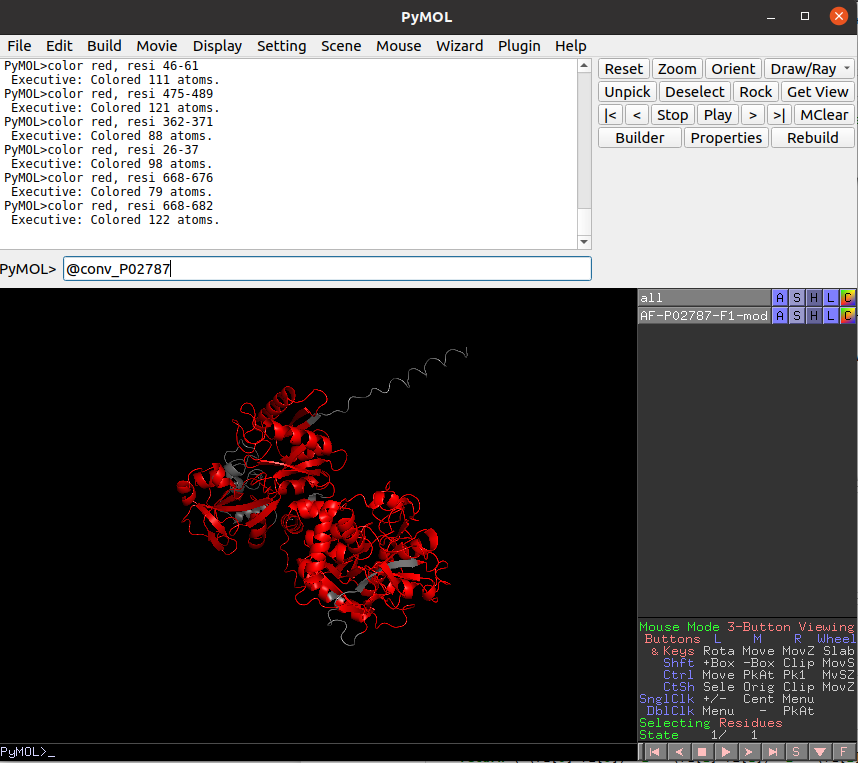

Видно, что покрытие не полное (не все покрасилось красным, см. презентацию)

In [13]:
def dist(r1, r2): #расстояние между 2 точками в пространстве
    return ( (r1[0]-r2[0])**2 + (r1[1]-r2[1])**2 + (r1[2]-r2[2])**2 )**(1/2)

In [14]:
cm_cleav = list() #центры масс непорезанных ARG/LYS
cm_not = list() #центры масс порезанных ARG/LYS

Заполняем cm_cleav и cm_not

Создаем pymol-скрипт forpym_P02787, красящий синим непорезанные ARG/LYS и зеленым порезанные

arg_lys_cm_cl, arg_lys_cm_not - расстояние от центра масс белка до порезанных и непорезанных аминокислот

In [15]:
f = open('forpym'+NAME, 'w')
f.write('color grey, all \n')

p=PDBParser(PERMISSIVE=1)
s = Struct.read('AF-'+NAME+'-F1-model_v1.pdb')
cm = s.center_of_mass()
print(cm)
arg_lys_cm_cl = list()
arg_lys_cm_not = list()
AL = ['ARG', 'LYS']

for aa in s.get_residues():
    if aa.get_resname() in AL:
        if aa.get_full_id()[3][1] not in cleavage:
            arg_lys_cm_not.append(dist(cm, aa.center_of_mass()))
            f.write('color blue, resi '+str(aa.get_full_id()[3][1]) + "\n")
            cm_not.append(aa.center_of_mass())
    
    if aa.get_full_id()[3][1] in cleavage:
        print(aa.get_full_id()[3][1], aa.get_resname(), aa.center_of_mass(), dist(cm, aa.center_of_mass()))
        arg_lys_cm_cl.append(dist(cm, aa.center_of_mass()))
        f.write('color green, resi '+str(aa.get_full_id()[3][1]) + "\n")
        cm_cleav.append(aa.center_of_mass())
f.close()

[0.6207134 3.5231872 0.8753065]
26 ARG [-13.9475155  24.633104   13.565495 ] 28.61647693979673
37 LYS [-11.440125  16.526613  27.734034] 32.18608545161228
46 LYS [-5.939125 30.051481 25.789116] 36.97944983832415
61 LYS [-22.537403  17.840446  16.981361] 31.63364162516953
69 ARG [-23.347364  14.494504   8.492249] 27.438228803361284
97 LYS [-7.655017 13.982675  4.669246] 13.866599233267143
107 LYS [ 8.13119   8.438479 21.992062] 22.9452541007802
122 LYS [-11.017565 -19.248343  32.227394] 40.45918265337439
135 LYS [-25.585014 -13.373996  25.413546] 39.67845930735358
143 ARG [-16.030888    1.0464326  16.855118 ] 23.211301920586255
212 LYS [-19.066317  -3.424234  32.433807] 37.83893208775071
215 LYS [-16.795025  -7.656027  34.60893 ] 39.57575214792917
220 ASP [-21.221474 -14.915948  26.557156] 38.42707638992156
225 LYS [-8.56018   -2.3579211 22.566692 ] 24.27740564390686
236 LYS [ -1.9620224 -11.796855   36.038322 ] 38.44232022378106
239 ARG [-5.0249357 -9.61301   33.654213 ] 35.76156940297

Должно получиться что-то такое
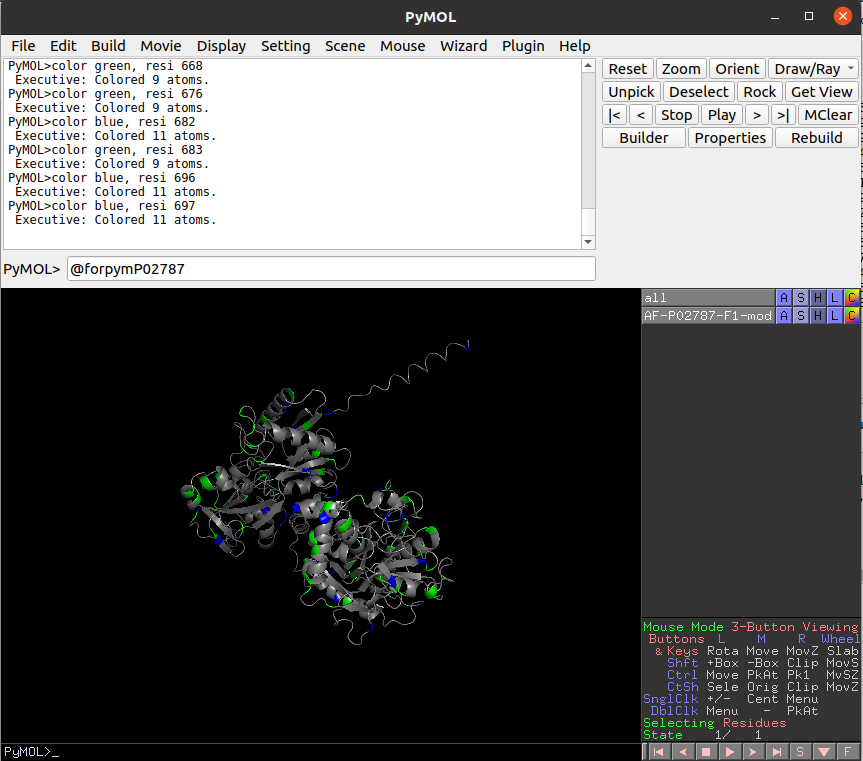

Строим распределение для расстояний от центров масс до порезанных и непорезанных ARG/LYS

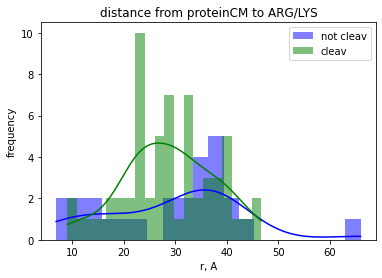

In [16]:
fig, ax = plt.subplots()
sns.histplot(arg_lys_cm_not, bins = 20, color = "blue", label = "not cleav", alpha = 0.5, kde = True, edgecolor=None)
sns.histplot(arg_lys_cm_cl,  bins = 20,  color = "green", label = "cleav", alpha = 0.5, kde=True, edgecolor=None)
ax.set_xlabel("r, A")
ax.set_ylabel("frequency")
ax.set_title("distance from proteinCM to ARG/LYS")
ax.legend()

И тут я поняла, что расстояние надо строить от поверхности...

## Распределение расстояний от поверхности до порезанных и непорезанных ARG/LYS

Дисклеймер: В Biopython есть [модуль](https://biopython.org/docs/1.75/api/Bio.PDB.ResidueDepth.html), который ищет [residue depth](https://en.wikipedia.org/wiki/Residue_depth) - глубину аминоислоты в белке. Но, к сожалению, нужная функция у меня не заработала, поэтому дальше вы увидите очень странный костыль :)

Сначала создадим поверхность белка с помощью pymol-скрипта create_mesh: он создает файл с расширением .obj - это расширение для хранения 3d структур (файлы достаточно большие, поэтому их лучше потом удалять, например, после создания таких файлов для 100 белков у меня закончилось место на диске)

In [17]:
! pymol create_mesh.pml -- {NAME}

 PyMOL(TM) 2.4.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected OpenGL version 4.6. Shaders available.
 Geometry shaders not available
 Detected GLSL version 4.60.
 OpenGL graphics engine:
  GL_VENDOR:   X.Org
  GL_RENDERER: AMD RENOIR (DRM 3.38.0, 5.8.0-59-generic, LLVM 11.0.0)
  GL_VERSION:  4.6 (Compatibility Profile) Mesa 20.2.6
 Detected 12 CPU cores.  Enabled multithreaded rendering.
PyMOL>s = str(sys.argv[1:][0])
PyMOL>name = 'AF-'+s+'-F1-model_v1.pdb'
PyMOL>from pymol import cmd
PyMOL>cmd.load(name)
PyMOL>show surface
PyMOL>cmd.save(s+'_mesh.obj')
PyMOL>quit


In [18]:
import trimesh #библиотека, работающая с 3d поверхностями

In [19]:
print(NAME)

P02787


In [20]:
mesh = trimesh.load(str(NAME+'_mesh.obj')) #загружаем наш файл

In [21]:
mesh.show()

Находим расстояния от порезанных и непорезанных аминокислот до поверхности

In [22]:
(closest_points,distances_cleav,triangle_id) = mesh.nearest.on_surface(np.array(cm_cleav))
(closest_points,distances_not,triangle_id) = mesh.nearest.on_surface(np.array(cm_not))

In [23]:
print(distances_cleav)
print(distances_not)

[0.54133375 0.80013008 1.94301752 ... 0.04928501 1.50521799 1.04147573]
[1.01411153 1.59882927 0.09831046 ... 0.37678897 0.92646518 0.82783581]


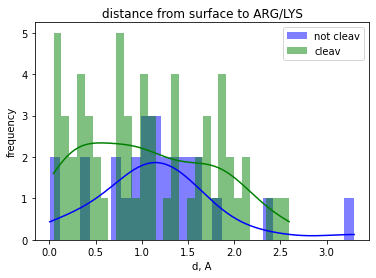

In [24]:
fig, ax = plt.subplots()
sns.histplot(distances_not, bins = 30, color = "blue", label = "not cleav", alpha = 0.5, kde = True, edgecolor=None)
sns.histplot(distances_cleav,  bins = 30,  color = "green", label = "cleav", alpha = 0.5, kde=True, edgecolor=None)
ax.set_xlabel("d, A")
ax.set_ylabel("frequency")
ax.set_title("distance from surface to ARG/LYS")
ax.legend()

## Статистический анализ

[Тест Колмогорова-Смирнова](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test): проверяет, из одного распределения 2 независимые выборки или нет

H0: cleav и not_cleav из одного распределения

PDF - плотность вероятности

CDF - функция вероятности

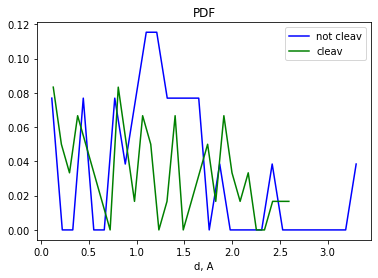

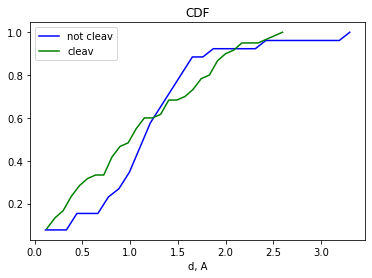

In [25]:
count_not, bins_count_not = np.histogram(distances_not, bins=30)
count_cleav, bins_count_cleav = np.histogram(distances_cleav, bins=30)

pdf_not = count_not / sum(count_not)
pdf_cleav = count_cleav / sum(count_cleav)

cdf_not = np.cumsum(pdf_not)
cdf_not = cdf_not / cdf_not[-1]
cdf_cleav = np.cumsum(pdf_cleav)
cdf_cleav = cdf_cleav/cdf_cleav[-1]

plt.plot(bins_count_not[1:], pdf_not, color="blue", label="not cleav")
plt.plot(bins_count_cleav[1:], pdf_cleav, color="green", label="cleav")
plt.title('PDF')
plt.xlabel('d, A')
plt.legend()
plt.show()
plt.plot(bins_count_not[1:], cdf_not, color="blue", label="not cleav")
plt.plot(bins_count_cleav[1:], cdf_cleav, color="green", label="cleav")
plt.title('CDF')
plt.xlabel('d, A')
plt.legend()
plt.show()

In [26]:
from scipy.stats import kstest
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [27]:
test_stat = kstest(distances_not, distances_cleav)
test_stat

KstestResult(statistic=0.21923076923076923, pvalue=0.2944612814222095)

In [28]:
mass = ProteinAnalysis(P).molecular_weight()/1000
mass #масса белка

77.06311470000036

In [29]:
with open('out.txt', "a") as fff: #сохраняем результаты в файл (код Uniprot, масса белка, p-value)
    fff.write(str(NAME) + " " + str(mass) + " " + str(test_stat.pvalue) + "\n")

p-value > 0.05, значит незлья сказать, что гипотеза выполнена в данном случае

## Как запускать для нескольих белков

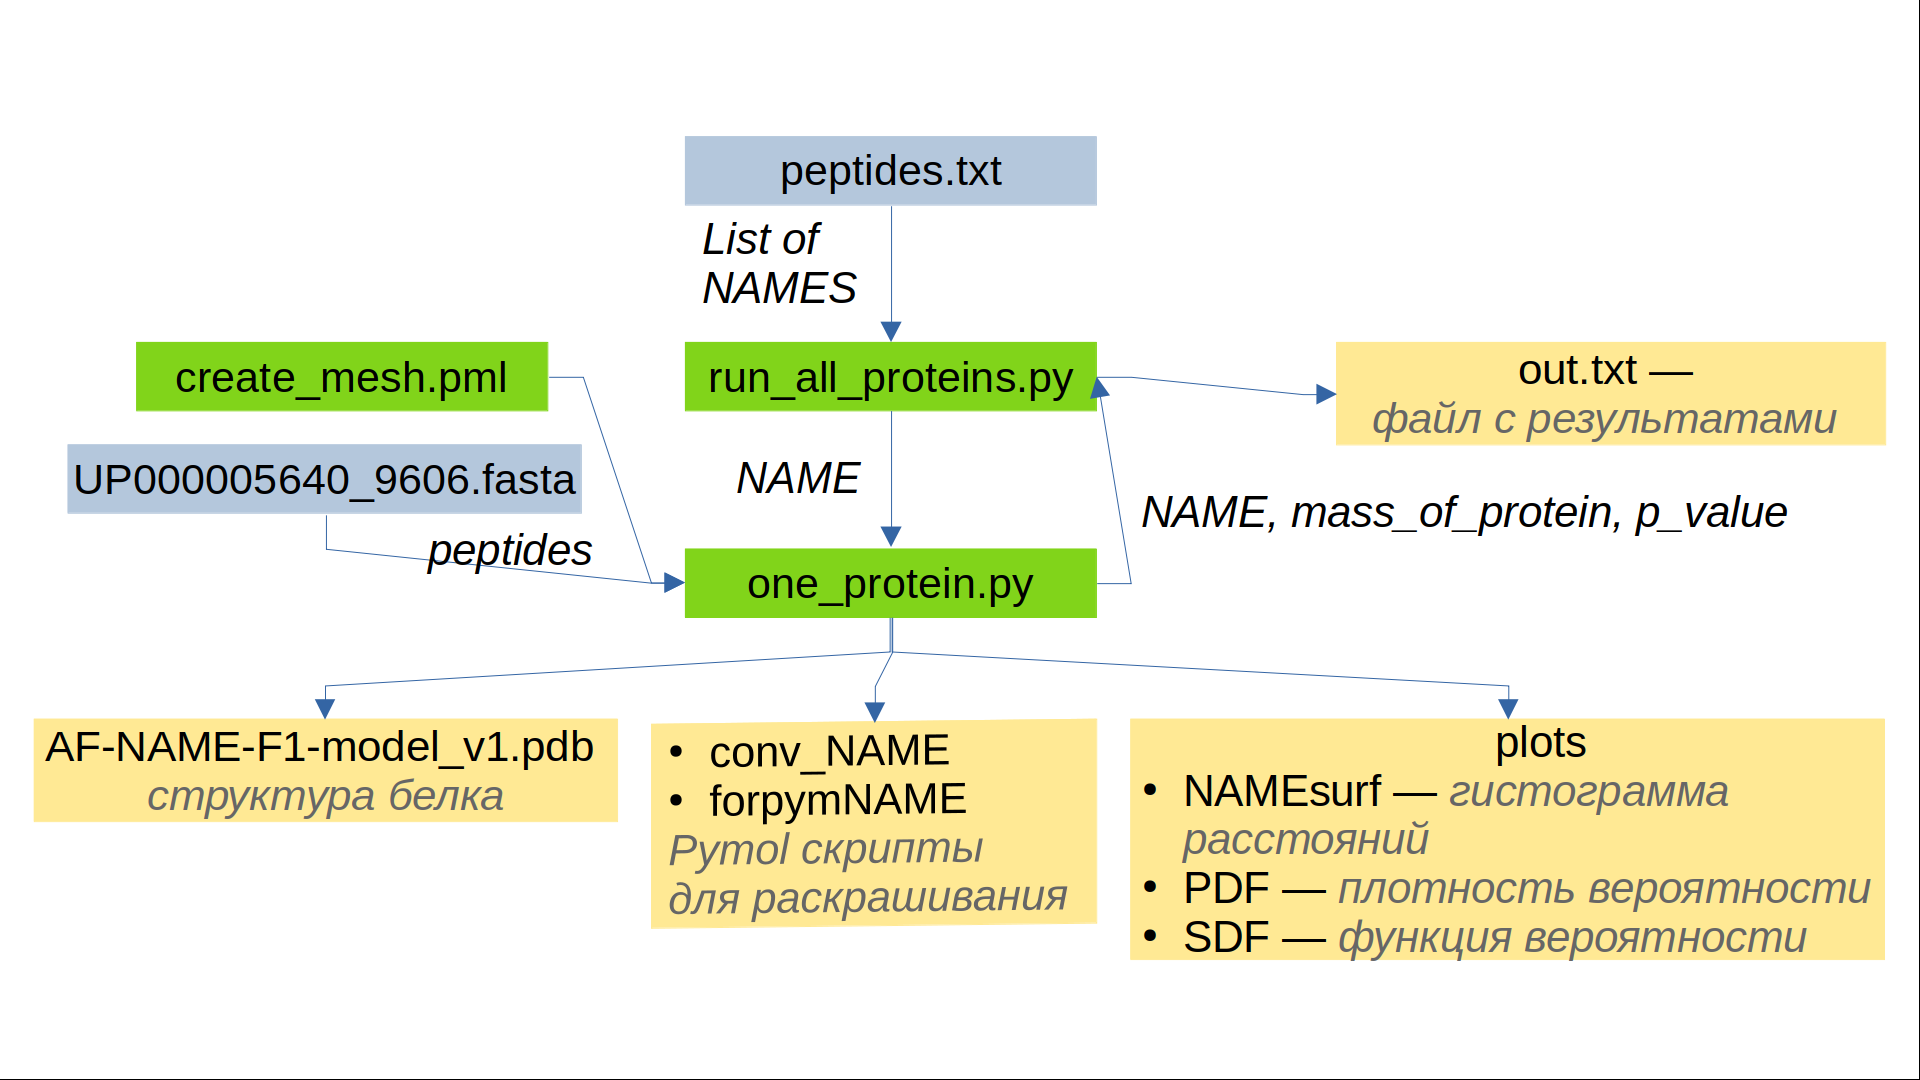

Создаем папку plot, в которой будут лежать все графики для белков

In [33]:
mkdir plot

mkdir: cannot create directory ‘plot’: File exists


Скрипт one_protein делает все вышеописанное для любого 1 белка, графики сохраняет в папку plot

Не пугайтесь, что он открывает и закрывает pymol, это он так строит поверхность белка create_mesh.pml, все ок :)

In [35]:
! python one_protein.py P02763 >nohup

А теперь самое интересное: посчитаем все для всех белков из списка protein_names.txt - 100 наиболее экспрессируемых белков (не все находится в uniprot, так что посчитается чуть меньше)

In [36]:
! python run_all_proteins.py

C9JA05
K7ERI9
A0M8Q6
P0DOY2
P01834
P01594
P01717
P80748
P01619
P02656
P01615
P06310
P06312
P02652
P69905
P02766
P68871
P02655
O95445
P02753
P0CG04
P35542
P02763
P19652
P05090
P02743
P02747
P02746
P02647
B1AKG0
P25311
P02649
P02750
P02749
P02760
P00739
P02765
P27169
P60709
O14791
P08185
P00738
P06727
P36955
P01009
P01011
P01042
P10909
P02679
P02790
P01008
P02774
P01019
P04217
P04004
P08697
P05155
P02675
P05546
P04196
P02748
P07357
P04003
P00748
P15636
P43652
P02768
P00734
P01042
P09871
P03952
P02787
P00736
P06396
P00747
P02671
P19827
B7ZKJ8
P13671
Q5T985
P00450
P08603
P00751
P01023
P01024
P01031
P0C0L5
P0C0L4
P02751
P04114


## Итоговый график

          0           1         2
86   A0M8Q6   11.253463  0.590909
2    A0M8Q6   11.253463  0.590909
16   A0M8Q6   11.253463  0.590909
17   P0DOY2   11.293434  0.888889
3    P0DOY2   11.293434  0.888889
..      ...         ...       ...
151  P0C0L5  192.749146  0.390962
82   P0C0L4  192.783177  0.283658
152  P0C0L4  192.783177  0.283658
83   P02751  262.621522  0.769449
153  P02751  262.621522  0.769449

[154 rows x 3 columns]


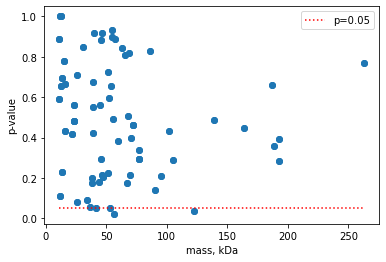

In [39]:
df = pd.read_csv('out.txt', header = None, sep = " ")
df = df.sort_values(by = [1])
print(df)
plt.scatter(df[1], df[2])
plt.hlines(0.05, min(df[1]), max(df[1]), color = 'red', linestyle = ':', label = 'p=0.05')
plt.xlabel('mass, kDa')
plt.ylabel('p-value')
plt.legend()

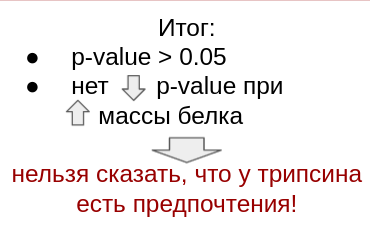